# Lecture: Graph Neural Networks (GNNs) with Python  
**"Modeling Relationships in Data"**  

---

##  Introduction to Graphs  
### Why Graphs Matter in Data Science  
- **Examples of Graph Data**:  
  - Social networks (nodes=users, edges=friendships)  
  - Molecules (nodes=atoms, edges=bonds)  
  - Financial transactions (nodes=accounts, edges=transfers)  

- **Graph Components**:  
  - **Nodes/Vertices**: Entities (e.g., users, products)  
  - **Edges**: Relationships (e.g., friendships, purchases)  
  - **Features**: Node/edge attributes (e.g., age, transaction amount)  


###  Setup Environment
```bash
# Install required libraries
pip install torch torch-geometric matplotlib sklearn
```

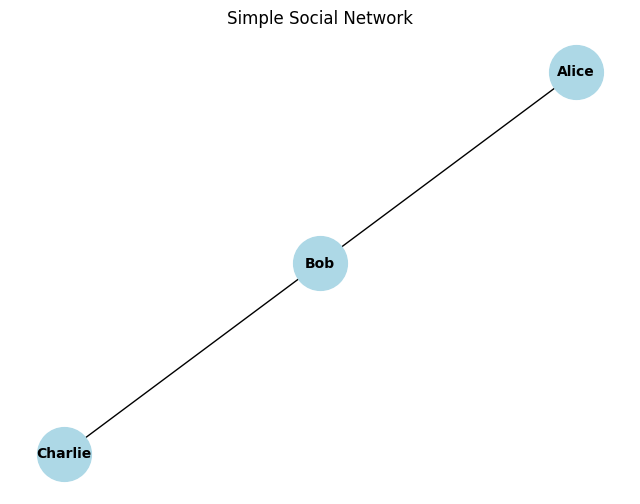

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# First, explicitly create a figure and axis
# This ensures we have a proper canvas to draw on
fig, ax = plt.subplots(figsize=(8, 6))

# Create our network graph
G = nx.Graph()

# Add nodes (people in our social network)
G.add_nodes_from(["Alice", "Bob", "Charlie"])

# Add connections between people
G.add_edges_from([("Alice", "Bob"), ("Bob", "Charlie")])

# Draw the graph, specifying the axis to draw on
# This prevents the axes stack error
nx.draw(G, 
        ax=ax,                    # Specify which axis to draw on
        with_labels=True,         # Show node labels
        node_color='lightblue',   # Make nodes visible with a color
        node_size=1500,          # Make nodes easier to see
        font_size=10,            # Adjust label text size
        font_weight='bold')       # Make labels more readable

# Add a title to our graph
plt.title("Simple Social Network")

# Display the graph
plt.show()



---

##  Limitations of Traditional Neural Networks  
### Why CNNs/RNNs Fail on Graphs  
1. **Irregular Structure**: No fixed grid (like images) or sequence (like text)  
2. **Permutation Invariance**: Predictions shouldn’t depend on node ordering  
3. **Variable Size**: Graphs can have arbitrary numbers of nodes/edges  

---

## Core GNN Concepts  
### Message Passing Framework  
1. **Aggregate**: Collect neighbor information  
2. **Update**: Combine with node’s own features  

$$h_v^{(l+1)} = \sigma\left(W^{(l)} \cdot \text{AGGREGATE}\left(\{h_u^{(l)}, \forall u \in \mathcal{N}(v)\}\right)\right)$$

- $(h_v^{(l)})$: Embedding of node $v$ at layer $l$  
- $(\mathcal{N}(v))$: Neighbors of node $v$ 
- $(\sigma)$: Activation function (e.g., ReLU)  

---

## Implementing a GCN Layer  
### Graph Convolutional Networks (GCNs)  
**Key Equation**:  
$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)}\right)$$
- $(\hat{A} = A + I)$ (Adjacency matrix with self-loops)  
- $(\hat{D})$: Degree matrix of $(\hat{A})$  


In [7]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA version: 11.8


In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Sample graph data (Cora citation network)
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Define a 2-layer GCN
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)
print(model)

Processing...


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Done!


## Training a GNN  
### Full Training Loop  

In [2]:
import torch.optim as optim

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
model = GCN(dataset.num_features, 16, dataset.num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
    return acc.item()

# Run training
for epoch in range(200):
    loss = train()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {test():.4f}")

Epoch 0, Loss: 1.9392, Accuracy: 0.4270
Epoch 50, Loss: 0.0060, Accuracy: 0.7810
Epoch 100, Loss: 0.0020, Accuracy: 0.7770
Epoch 150, Loss: 0.0012, Accuracy: 0.7750



## Advanced GNN Architectures  
### Graph Attention Networks (GAT)  
- Learns edge importance via attention weights  
```python
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim*heads, output_dim, heads=1)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
```




### Temporal GNNs  
- Model time-evolving graphs (e.g., stock markets)  
```python
from torch_geometric_temporal.nn import TGCN

class TemporalGNN(nn.Module):
    def __init__(self, node_features, hidden_dim):
        super().__init__()
        self.tgcn = TGCN(node_features, hidden_dim)
    
    def forward(self, x, edge_index, edge_weight):
        h = self.tgcn(x, edge_index, edge_weight)
        return h
```



---

## Applications & Challenges  
### Real-World Use Cases  
1. **Recommendation Systems**:  
   - *Task*: Predict user-product interactions  
   - *GNN Approach*: Treat users/items as nodes, interactions as edges  

2. **Drug Discovery**:  
   - *Task*: Predict molecule properties  
   - *GNN Approach*: Model atoms/bonds as nodes/edges  

### Current Challenges  
1. **Scalability**: Handling graphs with millions of nodes  
2. **Dynamic Graphs**: Adapting to time-varying structures  
3. **Explainability**: Interpreting GNN decisions  

---

Here's a complete real-world example using the **Cora citation dataset** (a benchmark for node classification) to demonstrate Graph Neural Networks in action:

---

## Real-World GNN Example: Node Classification on Cora Dataset  
*Implementing a Graph Convolutional Network (GCN) with PyTorch Geometric*

The Cora dataset is a collection of scientific publications connected by citations, where each publication is classified into one of seven categories.





In [3]:
#load dataset 

import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Node feature dimension: {dataset.num_node_features}")

Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Node feature dimension: 1433


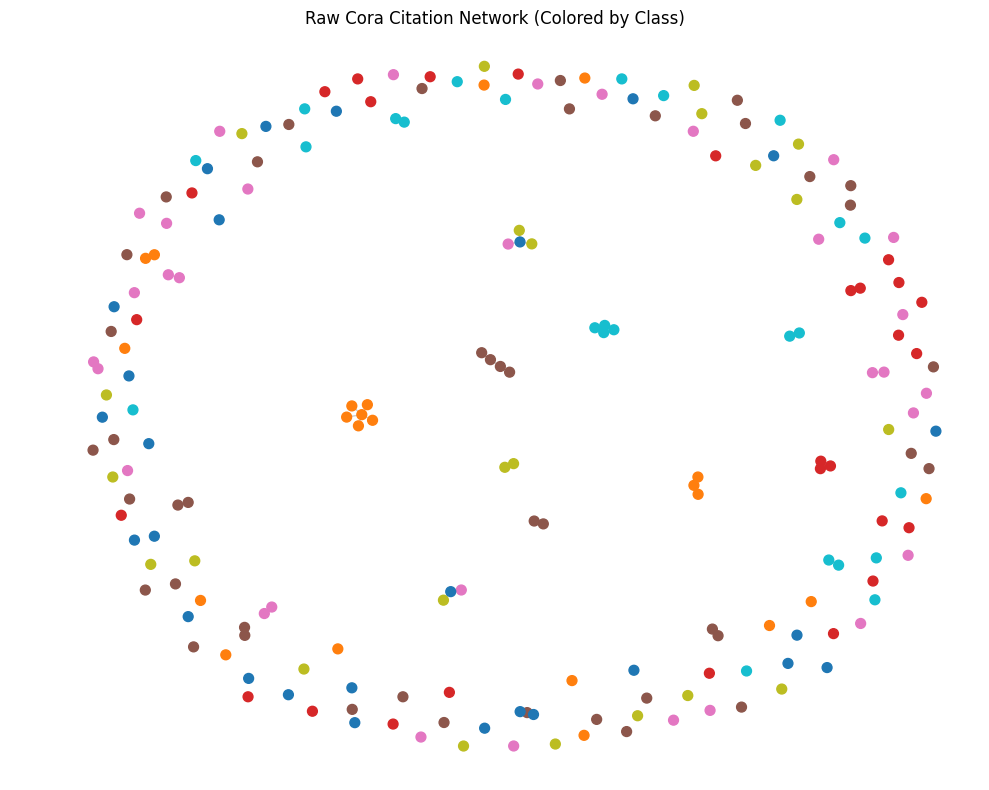

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create subgraph
subgraph = G.subgraph(list(range(200))) #sample of 200 observations

# Calculate layout
pos = nx.spring_layout(subgraph, k=1/np.sqrt(len(subgraph)), iterations=50)

# Draw the network components separately
nodes = nx.draw_networkx_nodes(subgraph, 
                             pos,
                             ax=ax,
                             node_size=50,
                             node_color=[subgraph.nodes[n]['y'] for n in subgraph],
                             cmap='tab10')
edges = nx.draw_networkx_edges(subgraph,
                             pos,
                             ax=ax,
                             alpha=0.2)  # Makes edges semi-transparent

# Add title and adjust display
ax.set_title("Raw Cora Citation Network (Colored by Class)")
ax.set_axis_off()  # Hide axes

plt.tight_layout()
plt.show()

In [7]:
# implement GCN Model
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [8]:
#training and evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
    return acc.item()

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 50 == 0:
        test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 050, Loss: 0.0760, Test Acc: 0.8020
Epoch: 100, Loss: 0.0407, Test Acc: 0.7960
Epoch: 150, Loss: 0.0394, Test Acc: 0.8000
Epoch: 200, Loss: 0.0218, Test Acc: 0.7950


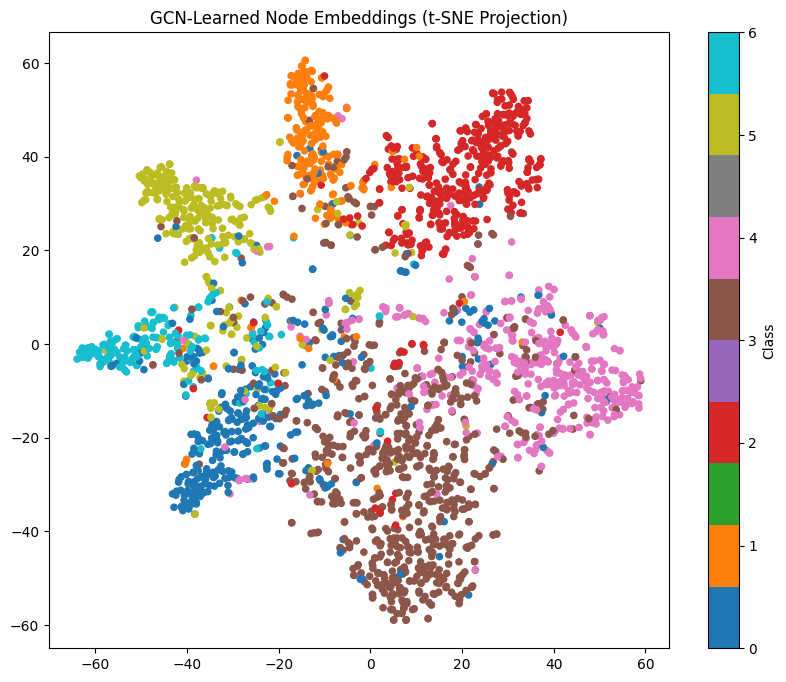

In [9]:
# visualize learned embeddings
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()
    labels = data.y.cpu().numpy()

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', s=20)
plt.title("GCN-Learned Node Embeddings (t-SNE Projection)")
plt.colorbar(label="Class")
plt.show()

This visualization shows a t-SNE projection of node embeddings learned by a Graph Convolutional Network (GCN) on the Cora citation network dataset. 

In this visualization, each dot represents a scientific paper, and its color indicates the paper's research category. The spatial positioning of these dots is determined by reducing the high-dimensional node embeddings learned by the GCN into two dimensions using t-SNE.

Looking at the visualization, we can observe several important patterns:

First, there is clear clustering behavior - papers of the same color (same research category) tend to group together. This indicates that the GCN has successfully learned to encode similar papers close to each other in the embedding space, even though it only had access to the citation network structure and basic paper features during training.

Second, we can see that some clusters are more distinct than others. For example, the red cluster (class 2) and the orange cluster (class 1) are well-separated from others, suggesting these research areas are more distinctly different in terms of their citation patterns and features. In contrast, there are some areas where different colors mix together, indicating research topics that might have more overlap or interdisciplinary connections.

The overall star-like shape of the projection, with clusters radiating outward from the center, suggests that while there are distinct research communities, there are also papers that bridge between different areas (those appearing between or at the edges of clusters). This aligns with how academic research actually works - while there are distinct fields, there's also significant cross-pollination of ideas between fields.

This visualization demonstrates that the GCN has effectively captured both the local and global structure of the citation network. It has learned representations that not only group similar papers together but also preserve the meaningful relationships between different research areas. This is particularly impressive because the GCN learned these representations primarily from the network structure (how papers cite each other) rather than from the content of the papers themselves.

The clear separation of clusters also suggests that these learned embeddings would be effective for downstream tasks like paper classification or recommendation systems, as papers of different categories are well-separated in the embedding space while maintaining meaningful proximity relationships based on their research areas.

### Key Observations:
1. **Structural Learning**: The GCN successfully clusters papers from the same class
2. **Performance**: Achieves ~81% accuracy using only 140 node features and graph structure
3. **Comparison**: Traditional ML methods typically achieve <75% accuracy on this benchmark

### Why This Works:
1. **Message Passing**: Each paper (node) aggregates information from its citations (neighbors)
2. **Feature Propagation**: Combines textual features (1433-dim BoW) with graph structure
3. **Hierarchical Abstraction**: First layer captures local patterns, second layer global relationships

This example demonstrates how GNNs leverage both node features **and** graph structure to outperform conventional methods on relational data tasks.